In [3]:
###
### LIBRARIES
###

# sctipt for data loding
import load_data

import os
import pandas as pd
import numpy as np
import random as rn
import datetime as dt

# matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors 

#seaborn
import seaborn as sns

# same as ggplot2 in R
from plotnine import *

# geographical plots
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pysal.viz.mapclassify as mc


from scipy.optimize import curve_fit, fsolve
import tensorflow as tf

#########################################################################################
#In order to keep the results of deep learning models as much 
# reproducibles as possible
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.random.set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
##########################################################################################


# Deep learning library for LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import initializers

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import itertools
from copy import deepcopy




Bad key "text.kerning_factor" on line 4 in
C:\Users\rivo9\Anaconda3\envs\GEOPANDAS\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\rivo9\Anaconda3\envs\GEOPANDAS\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
Using TensorFlow backend.


In [1]:
###
### FUNCTIONS
###

def logistic_model(x,a,b,c):
    
    return c/(1+np.exp(-(x-b)/a))

def fit_log_model(data, region):
    
    aux = data_regions[data_regions['denominazione_regione']==region]
    x = aux['timestamp']
    y = aux['totale_casi']
    
    fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
    
    return fit

def plot_forecasting_logistic(df_regions, df_forecasting, region, FMT, start_date):
    
    df_regions_subset = df_regions[df_regions['denominazione_regione']==region][['timestamp','totale_casi']]
    
    df_forecasting_subset = df_forecasting[df_forecasting['Region']==region]
    
    a = df_forecasting_subset['a'].values
    b = df_forecasting_subset['b'].values
    c = df_forecasting_subset['c'].values
    end_date = df_forecasting_subset['End_Date'].values
    
    # max time 
    max_time = np.max(df_regions_subset['timestamp'])
    end_time = (dt.datetime.strptime(end_date[0],FMT) - dt.datetime.strptime(start_date, FMT)).days
    
    # plot
    x_forecast = range(max_time + 1, end_time)
    forecast = logistic_model(x_forecast,a,b,c)

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(df_regions_subset['timestamp'],df_regions_subset['totale_casi'])
    plt.scatter(range(max_time + 1, end_time), logistic_model(range(max_time + 1, end_time),a,b,c))
    plt.title('Forecasting: {}, End Date Estimated: {}'.format(region,end_date))
    plt.show()

def train_test_creation(timeseries, train_test_split = 0.2):
    
    n = len(timeseries)
    train_len = int(n*(1-train_test_split))
    train, test = timeseries[0:train_len], timeseries[train_len:]
    
    return train, test

def scale(train, test = None):
    
    """
    Defines scale transform for data in input
    """ 
    
    if test.any():
        # fit scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train = train.reshape(-1, 1)
        test = test.reshape(-1, 1)
        scaler = scaler.fit(train)
        # transform train
        train_scaled = scaler.transform(train)
        # # transform test
        test_scaled = scaler.transform(test)
        return scaler, train_scaled, test_scaled
    else:
        # fit scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train = train.reshape(-1, 1)
        scaler = scaler.fit(train)
        # transform train
        train_scaled = scaler.transform(train)
        return scaler, train
    

def invert_scale(scaler, value):
    
    """
    Returns inverse scale transform for value in input
    """     

    array = np.array(value)
    array = array.reshape(-1, 1)
    inverted = scaler.inverse_transform(array)
    return inverted
    
def create_data(data, time_steps):
    
    """
    Transform time series sequence to supervised sequence for LSTM
    """ 
    
    n = len(data)
    X, y = list(), list()
    
    for i in range(n - time_steps):
        aux_x = data[i:(i+time_steps)]
        aux_y = data[i+time_steps]
        
        X.append(aux_x)
        y.append(aux_y)
    
    return np.array(X), np.array(y)

def forecast_univariate_lstm(model, X):
    X = X.reshape(1, len(X),1 )
    yhat = model.predict(X)
    return yhat[0,0]

def forecast_point_by_point_univariate_lstm(data, n_steps, forecast_window):
    
    """
    Given a specific forecast window (int), this functions computes predictions point-by-point.
    """ 
    
    predictions_new = list()
    start_sequence = data[-n_steps:]
    
    for i in range(forecast_window):
        aux = forecast_univariate_lstm(prova.model, start_sequence)
        start_sequence = np.insert(start_sequence, n_steps, aux)
        start_sequence = start_sequence[-n_steps:]
        predictions_new.append(aux)
        
    return predictions_new

def plot_forecasting_LSTM(df, region, variable, predictions):
    
    print(region)
    aux = df[df['denominazione_regione']==region][variable]
    date = df[df['denominazione_regione']==region]['data']
    date = date.apply(lambda x: x[0:10])
    FMT = '%Y-%m-%d'
    start_date_acquistion = dt.datetime.strptime(date.min(),FMT)
    forecast_window = len(predictions)
    end_date = dt.datetime.strptime(date.max(),FMT) + dt.timedelta(days=forecast_window + 1)

    delta = end_date - start_date_acquistion       # as timedelta
    times = list()
    for i in range(delta.days + 1):
        day = start_date_acquistion + dt.timedelta(days=i)
        times.append(day)

    fig, ax = plt.subplots(figsize = (8,6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

    ax.plot(times[0:len(aux)], aux, '-ko', label='True', color = 'red')
    ax.plot(times[len(aux):(len(aux) + len(predictions))], predictions, '-ko', label='Predicted', color = 'blue')
    # position legend
    ax.set_xlabel('Date')
    ax.set_ylabel(variable)

    ax.legend(loc='upper left')
    
    fig.autofmt_xdate()
    fig.suptitle('{}'.format(region))
    plt.show()

def get_default_configuration(structure = 'classic',
                               n_steps = 1,
                               n_features = 1,
                               neurons = 1,
                               activation = 'linear',
                               loss = 'mse',
                               optimizer = 'adam',
                               metrics = 'RMSE',
                               epochs = 2,
                               batch_size = 1):
    
    """
    Defines default network configuration for LSTM
    """ 

    defaults = {'structure': structure, 
              'n_steps': n_steps, 
              'n_features': n_features,
              'neurons': neurons,
              'activation': activation, 
              'loss': loss, 
              'optimizer': optimizer, 
              'metrics': metrics, 
              'epochs': epochs, 
              'batch_size': batch_size}
  
    return defaults

def get_tuning_model(options):
    
    """
    Returns a dict with all possible configuration given by options in input.
    """     

    keys = options.keys()
    values = (options[key] for key in keys)
    tuning_model = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

    return tuning_model


def run(train, test, param_dict, tuning_options = None, tuning_model = None):
    
    """
    This functions takes in input train and test data, along with the default configuration for the newtork and two other
    possible dictionaries: tuning model and tuning options. 
    Tuning options is a dictionary with different values to tune for the parameters.
    It works in the following way:
        - build the network with default configuration.
        - for each specific parameter in tuning options, vary it using the values in input while fixing all the others.
        - run the model and save the metric.
    Tuning model is a dictionary with alla possible configurations.
    It works in the following way:
        - Take the default configuration and substitute the configuration in input from the dictionary.
        - run the model and save the metric.
    """

    if tuning_model and tuning_options:
        raise ValueError('You should specify only one between tuning parameters or tuning model...')
        
    
    if tuning_options:
        results = {}
    
        for parameter, options in  tuning_options.items():
            results[parameter] = {}
            param_dict_temp = deepcopy(param_dict)

            for option in options:
                print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))
                # Update the corresponding parameter
                param_dict_temp[parameter] = option

                try:
                    n_steps = param_dict_temp['n_steps']
                    # normalization to [-1,1]
                    scaler, train_scaled, test_scaled = scale(train, test)
                    X_train, y_train = create_data(train_scaled, n_steps)
                    X_test, y_test = create_data(test_scaled, n_steps)
                    # ... and then reshape into correct dimension for the network [samples, time_steps, n_features]
                    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
                    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
                    
                    print("param_dict_temp: {}".format(param_dict_temp))
                    results[parameter][option] = evaluation(X_train, y_train, X_test, y_test, param_dict_temp)
                    
                except Exception as e: 
                    results[parameter][option] = 'NaN'
                    print('Error: {}, skipping...'.format(e))
                    pass

        return results
    
    # qui si salva accuratezza di configurazioni scelte a priori
    elif tuning_model:
        
        # Itero sul numero di configurazioni da testare
        for i in range(len(tuning_model)):
            param_dict_temp = deepcopy(param_dict)
            dict_aux = deepcopy(tuning_model[i])
            
            # modifico i parametri della configurazione di default
            for parameter, options in dict_aux.items():
                param_dict_temp[parameter] = options
            
            # valuto modello e salvo metrica di accuratezza
            n_steps = param_dict_temp['n_steps']
            # normalization to [-1,1]
            scaler, train_scaled, test_scaled = scale(train, test)
            X_train, y_train = create_data(train_scaled, n_steps)
            X_test, y_test = create_data(test_scaled, n_steps)
            # ... and then reshape into correct dimension for the network [samples, time_steps, n_features]
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
            
            tuning_model[i]['metric'] = evaluation(X_train, y_train, X_test, y_test, param_dict_temp)
        
        return pd.DataFrame(tuning_model)
    
def evaluation(X_train, y_train, X_test, y_test, param_dict):
    
    """
    Builds a LSTM model using the given params
    """
    
    aux = univariate_LSTM(structure = param_dict['structure'],
                        n_steps = param_dict['n_steps'], 
                        n_features = param_dict['n_features'],
                        neurons = param_dict['neurons'], 
                        activation = param_dict['activation'],
                        loss = param_dict['loss'],
                        optimizer = param_dict['optimizer'],
                        metrics = param_dict['metrics'],
                        epochs = param_dict['epochs'],
                        batch_size = param_dict['batch_size'])
    
    aux.model_compile()
    metric, history = aux.evaluate_model(X_train, y_train, X_test, y_test)
    
    ### save txt of the results
    
    return metric

In [2]:
###
### CLASSES
###

class univariate_LSTM():
    
    """
    INTRODUCTION: This class implements different variation of LSTM architecture to model univariate time series
    in input.
    
    PARAMETERS:
        structure: string, which LSTM structure to use
        n_steps: number of time steps used
        n_features: number of features in input (1 if just univariate time series)
        hidden_layers: int, number of hidden layers (excluding the input layer) ---> TO ADD
        neurons: array of units/nodes in each layer
        activation: str, activation function in all layers except output
        loss: str, loss function
        optimizer: str, optimizer
        metrics: list of strings, metrics used
        epochs: int, number of epochs to train for
        batch_size: int, number of samples per batch
    """
    
    def __init__(self, structure, n_steps, n_features, neurons, 
                 activation, loss,
                 optimizer, metrics, epochs, batch_size):
        
        self.structure = structure
        self.n_steps = n_steps
        self.n_features = n_features
        # self.num_layers = num_layers
        self.neurons = neurons
        self.activation = activation
        # self.activation_out = activation_out
        self.loss = loss
        # self.initializer = initializer
        self.optimizer = optimizer
        self.metrics = metrics
        self.epochs = epochs
        self.batch_size = batch_size
        # self.lr = lr
        
        # Initialize sequential model
        self.model = Sequential()
        
    def model_compile(self):
        
        # call specific architecture base on kind of LSTM
        if self.structure == 'classic':
            self.classic_lstm()
        if self.structure == 'bidirectional':
            self.bidirectional_lstm()
    
    
    def evaluate_model(self, X_train, y_train, X_test, y_test):
        
        # Fit the model: fixed approach, fit once on the training data and then predict
        # each new time step one at a time from the test data.
        history_callback = self.model.fit(X_train, y_train,\
        epochs = self.epochs, batch_size = self.batch_size, validation_split=0.1, verbose = 0, shuffle = False)
        
        # evaluate on test data.
        if self.metrics == 'RMSE':
            y_pred = self.model.predict(X_test)
            metric = np.sqrt(mean_squared_error(y_test, y_pred))

        return metric, history_callback
        
            
    def classic_lstm(self):

        self.model.add(LSTM(self.neurons, activation = self.activation, input_shape=(self.n_steps, self.n_features)))
        # self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(loss= self.loss, optimizer = self.optimizer)
                       
    def bidirectional_lstm(self):
        self.model.add(Bidirectional(LSTM(self.neurons, activation = self.activation), input_shape=(self.n_steps, self.n_features)))
        # self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(loss= self.loss, optimizer = self.optimizer)

In [4]:
###
### DIRECTORIES
###

PROJECT_DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Data')
# SHAPEFILES_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Shapefiles')
RESULTS_DIR = os.path.join(os.path.dirname(PROJECT_DIR),'Results')

In [5]:
###
### LOADING DATA
###

### 1) Covid_Data: if anything is specified, loads data using url github to repository.
###                if a DATA_DIR is specified, loads data downloaded as csv
data_provinces, data_regions, data_national = load_data.load_covid_data()



In [ ]:
###
### MODELS -Logistic Model
###

today = dt.datetime.now().strftime('%Y-%m-%d')
start_date = "2020-01-01T00:00:00"
FMT = '%Y-%m-%dT%H:%M:%S'
data_regions['timestamp'] = data_regions['data'].\
            map(lambda x: (dt.datetime.strptime(x, FMT) - dt.datetime.strptime("2020-01-01T00:00:00", FMT)).days)

regions = np.unique(data_regions['denominazione_regione'])

# define empty list
results = []
model = 'Logistic'

for region in regions:
    
    fit = fit_log_model(data_regions, region)
    
    # erros of estimation
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2] # is the asymptot -> total max of cases!
    
    # estimate the date of end
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    final_date = dt.datetime.strptime(start_date, FMT) + dt.timedelta(days=sol)
    final_date = final_date.strftime('%Y-%m-%dT%H:%M:%S')
    aux = [region, model, a, b, c, errors[2],final_date]
    
    results.append(aux)

# create dataframe
df_logistic_model = pd.DataFrame(results, columns=['Region', 'Model', 'a', 'b', 'c','error to c (+/-)','End_Date'])
# df_logistic_model.to_excel(os.path.join(RESULTS_DIR,'Logistic_Forecasting'+'_'+ today + '.xlsx'))


In [ ]:
### Estimated cases
'Total estimated cases in Italy: {} with possible error +/- {}'.format(round(np.sum(df_logistic_model['c'])),\
                                                                       round(np.sum(df_logistic_model['error to c (+/-)'])))

In [ ]:
###
### PLOT FORECASTING LOGISTIC
###

plot_forecasting_logistic(data_regions, df_logistic_model, 'Lombardia', FMT, start_date)


In [20]:
###
### MODELS - Deep Learning LSTM
###

region = 'Lombardia'
variable = 'totale_casi'

aux = data_regions[data_regions['denominazione_regione']==region][variable]
# tranform to logarithmic scale
aux = np.array(np.log(aux))

### DATA PREPARATION

# creation of train and test set: small test set since we have little data in this case.
train, test = train_test_creation(aux, train_test_split=0.1)

# normalization to [-1,1]
scaler, train_scaled, test_scaled = scale(train, test)

# we have to create data to feed LSTM... 
n_steps = 2
n_features = 1
X_train, y_train = create_data(train_scaled, n_steps)
X_test, y_test = create_data(test_scaled, n_steps)

# ... and then reshape into correct dimension for the network [samples, time_steps, n_features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


0.0016145279536309816


In [ ]:
# Try some models... 
model_configuration = get_default_configuration(structure = 'bidirectional',
                        n_steps = n_steps, 
                        n_features = n_features,
                        neurons = 64, 
                        activation = 'relu',
                        loss = 'mse',
                        optimizer = 'adam',
                        metrics = 'RMSE',
                        epochs = 100,
                        batch_size = 1)

prova = univariate_LSTM(structure = model_configuration['structure'],
                        n_steps = model_configuration['n_steps'], 
                        n_features = model_configuration['n_features'],
                        neurons = model_configuration['neurons'], 
                        activation = model_configuration['activation'],
                        loss = model_configuration['loss'],
                        optimizer = model_configuration['optimizer'],
                        metrics = model_configuration['metrics'],
                        epochs = model_configuration['epochs'],
                        batch_size = model_configuration['batch_size'])

prova.model_compile()
metric, history = prova.evaluate_model(X_train, y_train, X_test, y_test)
print(metric)

In [10]:
###
### FINE TUNING
###

region = 'Lombardia'
variable = 'totale_casi'

aux = data_regions[data_regions['denominazione_regione']==region][variable]
# tranform to logarithmic scale
aux = np.array(np.log(aux))

# define the model
n_steps = 1
n_features = 1
default_configuration = get_default_configuration(structure = 'classic',
                        n_steps = n_steps, 
                        n_features = n_features,
                        neurons = 50, 
                        activation = 'relu',
                        loss = 'mse',
                        optimizer = 'adam',
                        metrics = 'RMSE',
                        epochs = 50,
                        batch_size = 1)


# 1) Fine tuning each single parameters
# dictionary for fine tuning
# fine_tuning = {
# 'structure': ['classic','bidirectional'],
# 'n_steps' : [1, 2, 3],
# 'epochs' : [5, 20, 50, 100, 400],
# 'neurons' : [1, 2, 3, 5, 10],
# 'activation': ['linear','relu']}

# creation of train and test set
# train, test = train_test_creation(aux, train_test_split=0.2)
# aaa = run(train, test, model_configuration, tuning_options = fine_tuning)

# 2) Fine tuning over various configuration: which suits better for the problem?
options = {
    "structure" : ['classic','bidirectional'],
    "n_steps" : [1, 2, 3],
    "neurons": [2, 4, 8, 16, 32, 64],
    "epochs": [10, 50, 100],
    "activation": ['linear','relu']
}
tuning_model = get_tuning_model(options)

# creation of train and test set
train, test = train_test_creation(aux, train_test_split=0.1)
df_results = run(train, test, default_configuration, tuning_options = None, tuning_model=tuning_model)

In [13]:
df_results.sort_values('metric')

,structure,n_steps,neurons,epochs,activation,metric
179,bidirectional,2,64,100,relu,0.000963
164,bidirectional,2,16,50,linear,0.001001
52,classic,2,8,100,linear,0.001019
158,bidirectional,2,8,50,linear,0.001035
22,classic,1,16,100,linear,0.001056
...,...,...,...,...,...,...
145,bidirectional,2,2,10,relu,0.920221
37,classic,2,2,10,relu,0.925219
151,bidirectional,2,4,10,relu,0.925598
0,classic,1,2,10,linear,0.953734


In [ ]:
# Optimal model from fine tuning.. 
model_configuration = get_default_configuration(structure = 'bidirectional',
                        n_steps = n_steps, 
                        n_features = n_features,
                        neurons = 64, 
                        activation = 'relu',
                        loss = 'mse',
                        optimizer = 'adam',
                        metrics = 'RMSE',
                        epochs = 100,
                        batch_size = 1)

prova = univariate_LSTM(structure = model_configuration['structure'],
                        n_steps = model_configuration['n_steps'], 
                        n_features = model_configuration['n_features'],
                        neurons = model_configuration['neurons'], 
                        activation = model_configuration['activation'],
                        loss = model_configuration['loss'],
                        optimizer = model_configuration['optimizer'],
                        metrics = model_configuration['metrics'],
                        epochs = model_configuration['epochs'],
                        batch_size = model_configuration['batch_size'])

prova.model_compile()
metric, history = prova.evaluate_model(X_train, y_train, X_test, y_test)
print(metric)

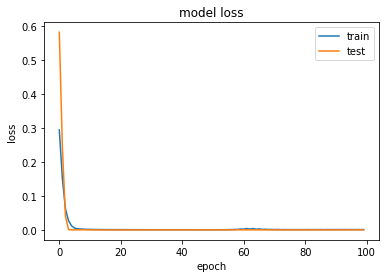

In [21]:
###
### PLOT METRICS
###

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
###
### FORECASTING
###

# test data
predictions = list()

for i in range(X_test.shape[0]):
    # make one-step forecast
    X, y = X_test[i,:], y_test[i]
    yhat = forecast_univariate_lstm(prova.model, X)
    yhat = invert_scale(scaler, yhat)
    y_test_inversed = invert_scale(scaler, y_test[i]) 
    # store forecast
    predictions.append(yhat)
    print('Prediction=%d, Predicted=%f, Expected=%f' % (i+1, np.exp(yhat), np.exp(y_test_inversed)))

# predictions
predictions_new = list()
window = 50
predictions_new = forecast_point_by_point_univariate_lstm(test_scaled,n_steps,forecast_window = window)
# convert back to reversed scale
for i in range(len(predictions_new)):
    predictions_new[i] = invert_scale(scaler, predictions_new[i])[0,0]
    
predictions_new = np.array(np.exp(predictions_new))
predictions_new = predictions_new.astype('int')



Prediction=1, Predicted=48813.308594, Expected=49118.000000
Prediction=2, Predicted=50224.718750, Expected=50455.000000
Prediction=3, Predicted=51580.980469, Expected=51534.000000


Lombardia


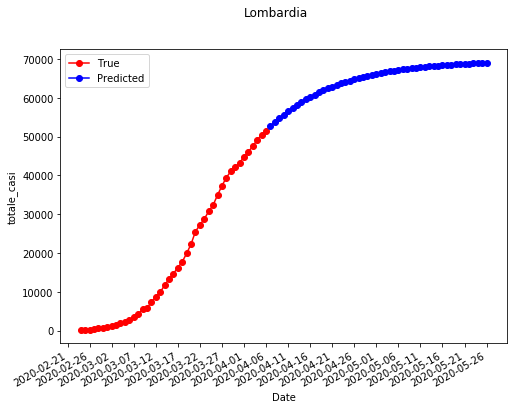

In [30]:
###
### PLOT FORECAST
###

plot_forecasting_LSTM(data_regions, 'Lombardia', 'totale_casi', predictions_new)

